# Phishing URL Detection

## Introduction

### Relevant Background Information

Phishing is a cybercrime that baits unknowing victims into clicking on URLs. This is done by acting like an authentic institution while contacting the victim through emails, texts, or other social media. Phishing assaults nowadays are advanced and progressively more troublesome to spot; additionally, as we rely more on our online profiles, phishing emails that take our sensitive information become more and more dangerous. Not only are phishing assaults dangerous to individuals, but they are also dangerous to huge corporations. For instance, one of the most extraordinary Phishing attacks includes the Colonial Pipeline scam, where over 3.4 billion euros were scammed out of the company. The attack was constructed by a simple email that gained access to passwords and planted malicious software onto the company network system. This caused the company to shut down and the oil prices to skyrocket. The seriousness and dangers of phishing can lead to extreme damage and have tragic consequences, so more sophisticated methods of systems are required to prevent phishing. To counteract the dangers of phishing, our group will classify URLs as 'phishing' or 'legitimate' to warn victims before the attackers steal their sensitive information.

### Predictive Question

Can we classify an URL as phishing or legitimate?

### Dataset used to answer the Question

The dataset used in this project comes from: https://data.mendeley.com/datasets/c2gw7fy2j4/3/files/575316f4-ee1d-453e-a04f-7b950915b61b

The dataset is used by the article <a href="https://www.sciencedirect.com/science/article/pii/S0952197621001950#">Towards benchmark datasets for machine learning based website phishing detection: An experimental study</a> which can be found in the <a href="https://www.sciencedirect.com/journal/engineering-applications-of-artificial-intelligence">Engineering Applications of Artificial Intelligence journal</a>.

## Methods & Results

### Overview

To successfully classify an URL as phishing or legitimate, we will be using the K-Nearest Neighbors Classification Algorithm. To perform this algorithm successfully, we will use Forward Selection to choose the relevant predictors, splitting the data into training and testing sets, and using Cross-fold validation to choose the optimal K value. Finally, we will test our model on the testing set. 

### Housekeeping

We start by loading the required libraries into R to allow us to perform data analysis.

In [229]:
library(plyr)
library(tidyverse)
library(repr)
library(tidymodels)
require(gridExtra)

### Gathering Data

Next, we use ```read_csv``` to read the data into R. (Notably, the CSV file is not hosted for use on data.mendeley.com; therefore, I am hosting the CSV file on my own server.)

In [230]:
options(repr.matrix.max.rows = 5)
phishing_data <- read_csv("https://brianhan.tech/media/dsci/dataset_phishing.csv")

Rows: 11430 Columns: 89
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): url, status
dbl (87): length_url, length_hostname, ip, nb_dots, nb_hyphens, nb_at, nb_qm...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Forward Selection

This data contains a lot of predictors:

In [231]:
colnames(phishing_data)
ncol(phishing_data)

[1] "url"                        "length_url"                
 [3] "length_hostname"            "ip"                        
 [5] "nb_dots"                    "nb_hyphens"                
 [7] "nb_at"                      "nb_qm"                     
 [9] "nb_and"                     "nb_or"                     
[11] "nb_eq"                      "nb_underscore"             
[13] "nb_tilde"                   "nb_percent"                
[15] "nb_slash"                   "nb_star"                   
[17] "nb_colon"                   "nb_comma"                  
[19] "nb_semicolumn"              "nb_dollar"                 
[21] "nb_space"                   "nb_www"                    
[23] "nb_com"                     "nb_dslash"                 
[25] "http_in_path"               "https_token"               
[27] "ratio_digits_url"           "ratio_digits_host"         
[29] "punycode"                   "port"                      
[31] "tld_in_path"                "tld_in_subdomain"          
[33] "abnormal_subdomain"         "nb_subdomains"             
[35] "prefix_suffix"              "random_domain"             
[37] "shortening_service"         "path_extension"            
[39] "nb_redirection"             "nb_external_redirection"   
[41] "length_words_raw"           "char_repeat"               
[43] "shortest_words_raw"         "shortest_word_host"        
[45] "shortest_word_path"         "longest_words_raw"         
[47] "longest_word_host"          "longest_word_path"         
[49] "avg_words_raw"              "avg_word_host"             
[51] "avg_word_path"              "phish_hints"               
[53] "domain_in_brand"            "brand_in_subdomain"        
[55] "brand_in_path"              "suspecious_tld"            
[57] "statistical_report"         "nb_hyperlinks"             
[59] "ratio_intHyperlinks"        "ratio_extHyperlinks"       
[61] "ratio_nullHyperlinks"       "nb_extCSS"                 
[63] "ratio_intRedirection"       "ratio_extRedirection"      
[65] "ratio_intErrors"            "ratio_extErrors"           
[67] "login_form"                 "external_favicon"          
[69] "links_in_tags"              "submit_email"              
[71] "ratio_intMedia"             "ratio_extMedia"            
[73] "sfh"                        "iframe"                    
[75] "popup_window"               "safe_anchor"               
[77] "onmouseover"                "right_clic"                
[79] "empty_title"                "domain_in_title"           
[81] "domain_with_copyright"      "whois_registered_domain"   
[83] "domain_registration_length" "domain_age"                
[85] "web_traffic"                "dns_record"                
[87] "google_index"               "page_rank"                 
[89] "status"

[1] 89

Notably, a lot of predictors are not attainable through the URL alone. For instance, we can't know the ```google_index``` through the phishing URL alone (we would need another service). To answer the question: "Can we classify an URL as phishing or legitimate?" we will only select the predictors that can be directly obtained from the URL.

After filtering for predictors that are directly obtained from the URL, we will select the ones that we find important (Note: Ideally, we will perform forward selection on all of these variables; however, that would take ***way*** too long).

In [232]:
phishing_subset <- phishing_data |>
                   select(status, length_url, length_hostname, nb_dots, nb_hyphens, nb_at, nb_qm, nb_and, nb_or, nb_eq, nb_underscore, nb_tilde,
                          nb_percent, nb_slash, nb_star, nb_colon, nb_comma, nb_semicolumn, nb_dollar, nb_space, http_in_path, https_token, 
                          ratio_digits_url, ratio_digits_host, nb_subdomains,longest_word_host, longest_word_path, avg_words_raw, avg_word_host, 
                          domain_registration_length)
ncol(phishing_subset)

[1] 30

After selecting for slimming down the dataset to 30 columns, we will be performing forward selection. Credit for the code goes to <a href="https://datasciencebook.ca/classification2.html#forward-selection-in-r">datasciencebook.ca, Classification II: evaluation & tuning, 6.8.3 Forward Selection in R</a>.

```r
phishing_subset <- phishing_data |>
                   select(status, length_url, length_hostname, nb_dots, nb_hyphens, nb_at, nb_qm, nb_and, nb_or, nb_eq, nb_underscore, nb_tilde,
                          nb_percent, nb_slash, nb_star, nb_colon, nb_comma, nb_semicolumn, nb_dollar, nb_space, http_in_path, https_token, 
                          ratio_digits_url, ratio_digits_host, nb_subdomains,longest_word_host, longest_word_path, avg_words_raw, avg_word_host, 
                          domain_registration_length) %>%
                   mutate(https_token = as_factor(https_token))

names <- colnames(phishing_subset |> select(-status))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
phishing_vfold <- vfold_cv(phishing_subset, v = 5, strata = status)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("status", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        phishing_recipe <- recipe(as.formula(model_string), 
                                  data = phishing_subset) |>
                          step_scale(all_numeric_predictors()) |>
                          step_center(all_numeric_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
               add_recipe(phishing_recipe) |>
               add_model(knn_spec) |>
               tune_grid(resamples = phishing_vfold, grid = 10) |>
               collect_metrics() |>
               filter(.metric == "accuracy") |>
               summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
```

As the code takes a very long time to run, we have not included it in this file. The running of the code can be seen in the ```Topic Proposal.ipynb``` file, and we will load the results from the ```accuracies.csv``` file.

In [233]:
accuracies <- read_csv("accuracies.csv")
head(accuracies, 2)

Rows: 29 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): model_string
dbl (2): size, accuracy

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


size,model_string,accuracy
<dbl>,<chr>,<dbl>
1,status ~ longest_word_path,0.6675416
2,status ~ longest_word_path+domain_registration_length,0.7453193


By organizing the output from forward selection, we would find the predictors that are most useful in classifying an URL as phishing or legitimate. 

In [234]:
accuracies <- accuracies %>%
              arrange(desc(accuracy))
head(accuracies, 4)

size,model_string,accuracy
<dbl>,<chr>,<dbl>
16,status ~ longest_word_path+domain_registration_length+nb_hyphens+nb_slash+nb_dots+ratio_digits_url+length_hostname+avg_word_host+longest_word_host+length_url+nb_underscore+nb_at+ratio_digits_host+http_in_path+nb_semicolumn+nb_tilde,0.8597550
17,status ~ longest_word_path+domain_registration_length+nb_hyphens+nb_slash+nb_dots+ratio_digits_url+length_hostname+avg_word_host+longest_word_host+length_url+nb_underscore+nb_at+ratio_digits_host+http_in_path+nb_semicolumn+nb_tilde+nb_or,0.8597550
18,status ~ longest_word_path+domain_registration_length+nb_hyphens+nb_slash+nb_dots+ratio_digits_url+length_hostname+avg_word_host+longest_word_host+length_url+nb_underscore+nb_at+ratio_digits_host+http_in_path+nb_semicolumn+nb_tilde+nb_or+nb_dollar,0.8596675
19,status ~ longest_word_path+domain_registration_length+nb_hyphens+nb_slash+nb_dots+ratio_digits_url+length_hostname+avg_word_host+longest_word_host+length_url+nb_underscore+nb_at+ratio_digits_host+http_in_path+nb_semicolumn+nb_tilde+nb_or+nb_dollar+nb_star,0.8596675


Notably, the highest accuracy is a tie for 0.8597550. We chose to have fewer predictors (16) to decrease the number of computations our model requires (multicollinearity does not apply to Knn Neighbors).

### Clean Up and Splitting the Data

Now, we will clean up our data set by only selecting the relevant variables, which we found by performing the forward selection algorithm.

In [235]:
cleaned_phishing_data <- phishing_data %>%
                         select(status, longest_word_path, domain_registration_length, nb_hyphens, nb_slash, nb_dots, ratio_digits_url,
                                length_hostname, avg_word_host, longest_word_host, length_url, nb_underscore, nb_at, ratio_digits_host, http_in_path,
                                nb_semicolumn, nb_tilde) %>%
                         mutate(status = as_factor(status))

Continuing on, we will split the data into training and testing data sets with the proportion of 75% of the data for training and 25% of the data for testing. This allows us to get metrics on how well our model will do in the real world. Because ```initial_split``` uses randomization, we will set a seed to ensure that the results are reproducible.

In [236]:
set.seed(0717)
cleaned_phishing_data_split <- initial_split(cleaned_phishing_data, prop = 3/4, strata = status)
phishing_train <- training(cleaned_phishing_data_split)
phishing_test <- testing(cleaned_phishing_data_split)

### Checking for imbalance (exploring the training data)

To explore the training set, we will be making a bar graph to compare the number of rows with legitimate and phishing data. We are doing this to ensure that there is no data imbalance.

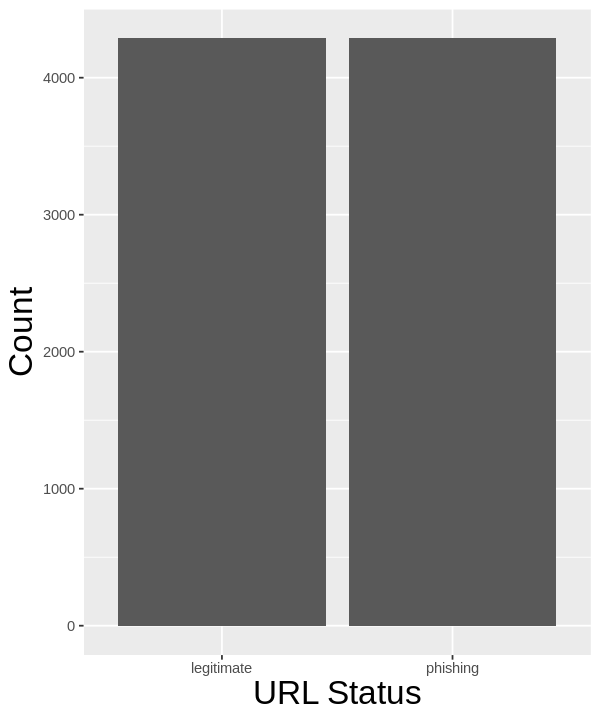

In [274]:
options(repr.plot.width = 5, repr.plot.height = 6) 

phishing_status_count <- phishing_train %>%
                         select(status) %>%
                         group_by(status) %>%
                         dplyr::summarize(n = n())

phishing_data_exploration <- phishing_status_count %>%
                             ggplot(aes(x = status, y = n)) +
                                 geom_bar(stat = "identity") +
                                 labs(x = "URL Status", y = "Count") +
                                 theme(axis.title = element_text(size = 20))

phishing_data_exploration

As our bar graph shows, the bars of phishing and legitimate URLs are equal lengths. This ensures that our trianing data is balanced.

### Using 5-Fold Cross-Validation to get the Optimal Value of K (number of nearest neighbors)

Continuing on, we will scale 

In [238]:
phishing_recipe <- recipe(status ~ ., data = phishing_train) %>%
                   step_scale(all_predictors()) %>%
                   step_center(all_predictors())

Then, we use ```vfold_cv``` to splits our training data into 5 folds automatically, and because ```vfold``` uses randomization, we will be setting a seed to ensure that the result is reproducible.

In [239]:
set.seed(931)
phishing_vfold <- vfold_cv(phishing_train, v = 5, strata = status)

Using ```tune()```, R allows us to specify that we want to tune the parameter ```neighbors```.

In [240]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

We find the values of K we want to try by using ```seq()```.

In [241]:
k_vals <- tibble(neighbors = seq(from = 1, to = 5, by = 1))

Finally, we create a workflow to find the optimal value of K using the recipe, model, and our cross-validation settings we have created above.

In [242]:
knn_results <- workflow() %>%
               add_recipe(phishing_recipe) %>%
               add_model(knn_spec) %>%
               tune_grid(resamples = phishing_vfold, grid = k_vals) %>%
               collect_metrics()

By creating a plot of neighbors vs. accuracy estimate, we can find the optimal value of K (the number of neighbors with the highest accuracy estimate).

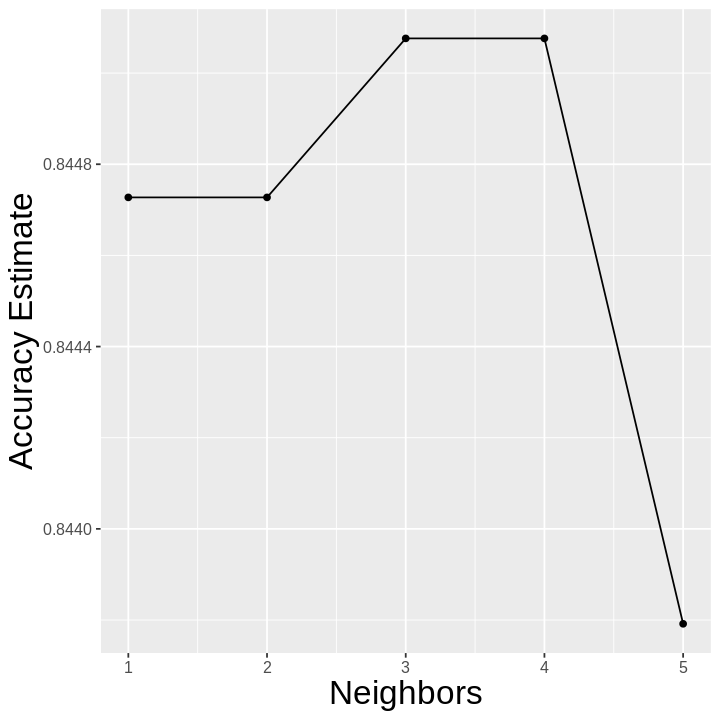

In [243]:
options(repr.plot.width = 6, repr.plot.height = 6)

k_accuracies <- knn_results |>
                filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(k_accuracies, aes(x = neighbors, y = mean)) +
                     geom_point() +
                     geom_line() +
                     labs(x = "Neighbors", y = "Accuracy Estimate") + 
                     theme(axis.title = element_text(size = 20),
                           text = element_text(size = 12))

accuracy_vs_k

Looking at the graph, we can conclude that ```K``` is equal to 3 or 4. In fear of overfitting the model, we will choose ```K = 4```.

*Notably, we tried K from 1 to 100; however, as it would take too long to compute, we watered it down for the group project.*

### Creating the Actual Model

Now that we have organized the data and found the optimal value of ```K```, we can start creating the actual model.

To create the model, we start by creating a new model specification. This time, we will use the value of ```K``` we found through cross-validation instead of ```tune()```.

In [244]:
actual_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) %>%
                   set_engine("kknn") %>%
                   set_mode("classification")

Then, we will create a new workflow, fitted for the model, by utilizing the recipe we had built in the cross-validation step, and the new model specification we built using the optimal value of ```K``` found in the cross-validation step.

In [245]:
knn_fit <- workflow() %>%
           add_recipe(phishing_recipe) %>%
           add_model(actual_knn_spec) %>%
           fit(data = phishing_train)

### Testing the model and Analysis

To understand how well our model performs, we will be testing the model by using ```predict()``` and the testing data set we have set up during ‘Clean Up and Splitting the Data.’ We also use ```bind_cols``` to compare the predicted value and the actual value.

In [246]:
knn_predict <- knn_fit %>%
               predict(phishing_test) %>%
               bind_cols(phishing_test)

To see how well the model performs, we will get our model's accuracy by filtering ```.metric``` and selecting the ```.estimate``` column.

In [247]:
knn_rmpse <- knn_predict %>%
             metrics(truth = status, estimate = .pred_class) %>%
             filter(.metric == "accuracy")

knn_rmpse

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8607418


Looking at the accuracy of the classifier on the test data, we understand that the estimated accuracy of the classifier on the test data was 86%.

To better understand what this '86%' implies, we will create a confusion matrix.

In [276]:
# Create Confusion matrix
confusion_matrix <- knn_predict %>%
                    conf_mat(truth = status, estimate = .pred_class)

confusion_matrix

            Truth
Prediction   legitimate phishing
  legitimate       1255      224
  phishing          174     1205

And to visually interpret the confusion matrix, we created visuals showing the distribution of righ tand wrong predictions.

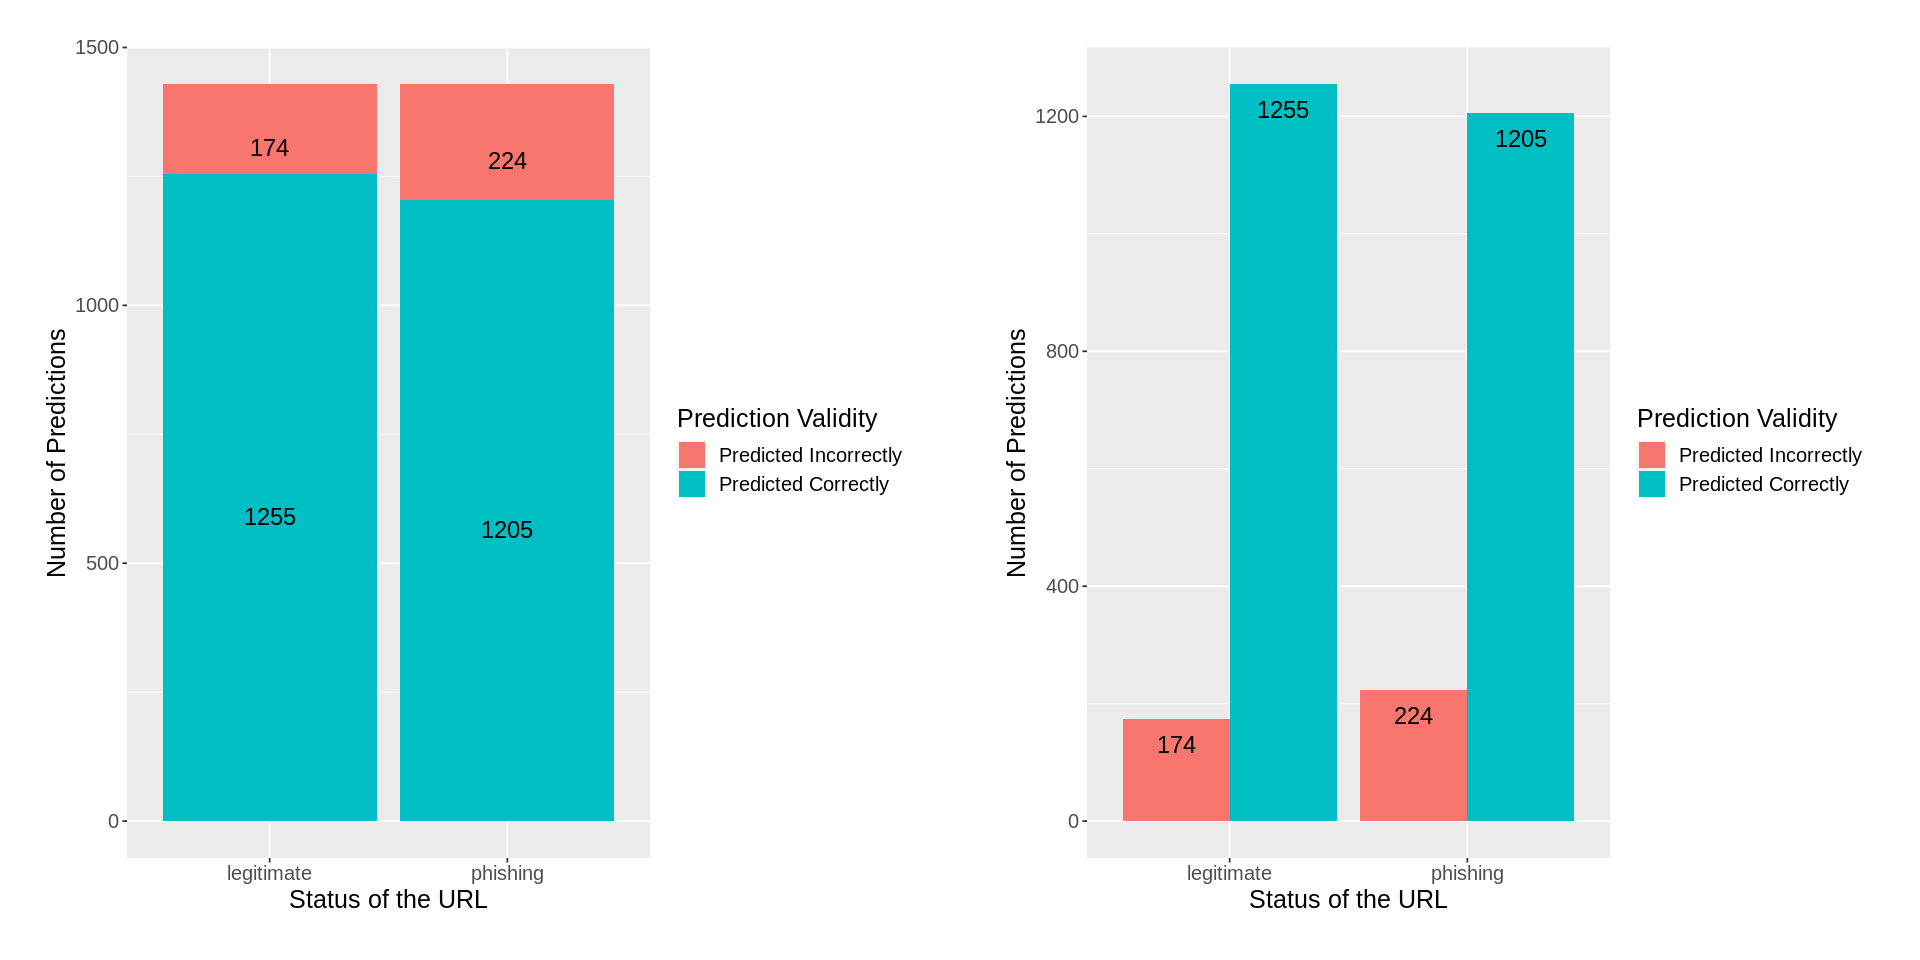

In [277]:
options(repr.plot.width = 16, repr.plot.height = 8) 

# Adding column for Prediction != Truth, then it is wrong.
confusion_matrix_tibble <- confusion_matrix$table %>%
                           as_tibble() %>%
                           add_column(validity = c("Predicted Correctly", 
                                                   "Predicted Incorrectly", 
                                                   "Predicted Incorrectly", 
                                                   "Predicted Correctly"))

# Reordered tibble
confusion_matrix_tibble <- confusion_matrix_tibble[c(1,2,4,3), ]

# Arranged column "W' and "C" to display properly on segmented bar graph.
confusion_matrix_tibble$validity <- factor(confusion_matrix_tibble$validity, 
                                           levels = c("Predicted Incorrectly", 
                                                      "Predicted Correctly"))

# Create Bar Graph
confusion_matrix_bar_graph <- confusion_matrix_tibble %>%
                              ggplot(aes(x = Truth, y = n, fill = validity)) +
                                  geom_bar(stat = "identity", position = "dodge") +
                                  geom_text(aes(label = n), vjust = 2, 
                                            position = position_dodge(0.9), size=5) +
                                  labs(x = "Status of the URL", 
                                       y = "Number of Predictions", 
                                       fill = "Prediction Validity") +
                                  theme(axis.title = element_text(size = 15),
                                        text = element_text(size = 15),
                                        plot.margin = unit(c(1,1,1,1), "cm"))

# Getting position for y-axis label
confusion_matrix_cumsum <- ddply(confusion_matrix_tibble, 
                                 "Truth", 
                                 transform, 
                                 label_ypos=cumsum(n) - 0.5*n)

# Create segmented bar graph
confusion_matrix_segmented_bar_graph <- confusion_matrix_cumsum %>%
                                        ggplot(aes(x = Truth, y = n, fill = validity)) +
                                            geom_bar(stat = "identity") + 
                                            geom_text(aes(y=label_ypos, label = n), 
                                                      vjust = 1.6, 
                                                      size=5) +
                                            labs(x = "Status of the URL", 
                                                 y = "Number of Predictions", 
                                                 fill = "Prediction Validity") +
                                            theme(axis.title = element_text(size = 15),
                                                  text = element_text(size = 15),
                                                  plot.margin = unit(c(1,1,1,1), "cm"))

# arrange grid
grid.arrange(confusion_matrix_segmented_bar_graph, confusion_matrix_bar_graph, ncol = 2)

The confusion matrix and its subsequent visualizations tell us the distribution of predictions created by our model. Out of the 2858 data points in our test data, our model predicted 2473 points correctly and 385 points incorrectly. This includes 176 legitimate URLs classified as phishing (False Negative) and 227 phishing URLs classified as legitimate (False Positive).

Our model predicts False Positives a lot more than False Negatives. This is a problem as the case for a False Positive is much direr than a False Negative. This is because a False Positive classification can mean a user losing his/her data and getting their identity stolen. In contrast, a False Negative could mean the user is warned about going to a malicious URL. This should be addressed in future iterations of the model, where uncertainty should lead to False Negatives (the more cautious prediction) rather than False Positives.

## Discussion

## Works Cited